In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import os
import statistics

In [2]:
work_dir = os.getcwd()
work_dir

'C:\\Users\\Evan\\Documents\\GitHub\\FuturesStrategy'

## Read the Data

In [164]:
Data_path = os.path.join(work_dir, 'Data')
TX = pd.read_csv(os.path.join(Data_path, 'TX.csv'), encoding = 'cp950')
OI = pd.read_csv(os.path.join(Data_path, 'MTXOpenInterest.csv'), encoding = 'cp950')
SumOptionOI = pd.read_csv(os.path.join(Data_path, 'SumOptionOI.csv'), encoding = 'cp950')
ForOptionOI = pd.read_csv(os.path.join(Data_path, 'ForOptionOI.csv'), encoding = 'cp950') 
TX['日期'] = pd.to_datetime(TX['日期']) 
OI['日期'] = pd.to_datetime(OI['日期']) 
SumOptionOI['日期'] = pd.to_datetime(SumOptionOI['日期']) 
ForOptionOI['日期'] = pd.to_datetime(ForOptionOI['日期']) 

In [165]:
ForOptionOI.head()

,日期,外資Call未平倉金額,外資Put未平倉契約金額
0,2017-04-24,162638,234152
1,2017-04-25,225903,154223
2,2017-04-26,236715,149876
3,2017-04-27,220901,149830
4,2017-04-28,210382,133524


In [166]:
ForOptionOI = ForOptionOI[ForOptionOI.日期.isin(OI.日期.unique())]

In [167]:
ForOptionOI.shape

(735, 3)

In [168]:
OI.shape

(735, 4)

 Aggregating the open interest of Institutional investors

In [132]:
OI['三大法人總和'] = OI['自營商'] + OI['外資'] + OI['投信']

In [133]:
OI.tail()

,日期,自營商,外資,投信,三大法人總和
730,2020-04-16,1413602,1575209,42234,3031045
731,2020-04-17,2244324,-367902,42780,1919202
732,2020-04-20,1756390,-2425912,34568,-634954
733,2020-04-21,1538302,-2029498,33647,-457549
734,2020-04-22,914106,-2022450,32710,-1075634


## We take out the closest delivery TX as out underlying.  台指近日

In [64]:
TX00 = TX.drop_duplicates(subset = ['日期'], keep = 'first').reset_index(drop=True)

In [65]:
TX00.head()

,期貨名稱,日期,到期月,開盤價,收盤價,每日結算價,未平倉合約數,無風險利率
0,TX201705 台指 2017/05,2017-04-24,May-17,9747.0,9705.0,9706,86630,1.045
1,TX201705 台指 2017/05,2017-04-25,May-17,9746.0,9813.0,9814,88368,1.045
2,TX201705 台指 2017/05,2017-04-26,May-17,9855.0,9841.0,9842,88047,1.045
3,TX201705 台指 2017/05,2017-04-27,May-17,9829.0,9839.0,9838,88742,1.045
4,TX201705 台指 2017/05,2017-04-28,May-17,9847.0,9857.0,9856,88286,1.045


In [66]:
TX00['CC'] = TX00['每日結算價'].pct_change()
TX00['OC'] = (TX00['收盤價'] - TX00['開盤價'])/TX00['開盤價']

In [67]:
TX00.head()

,期貨名稱,日期,到期月,開盤價,收盤價,每日結算價,未平倉合約數,無風險利率,CC,OC
0,TX201705 台指 2017/05,2017-04-24,May-17,9747.0,9705.0,9706,86630,1.045,NaN,-0.004309
1,TX201705 台指 2017/05,2017-04-25,May-17,9746.0,9813.0,9814,88368,1.045,0.011127,0.006875
2,TX201705 台指 2017/05,2017-04-26,May-17,9855.0,9841.0,9842,88047,1.045,0.002853,-0.001421
3,TX201705 台指 2017/05,2017-04-27,May-17,9829.0,9839.0,9838,88742,1.045,-0.000406,0.001017
4,TX201705 台指 2017/05,2017-04-28,May-17,9847.0,9857.0,9856,88286,1.045,0.001830,0.001016


In [68]:
TX00.dtypes

期貨名稱              object
日期        datetime64[ns]
到期月               object
開盤價              float64
收盤價              float64
每日結算價              int64
未平倉合約數             int64
無風險利率            float64
CC               float64
OC               float64
dtype: object

## Show the TX first 

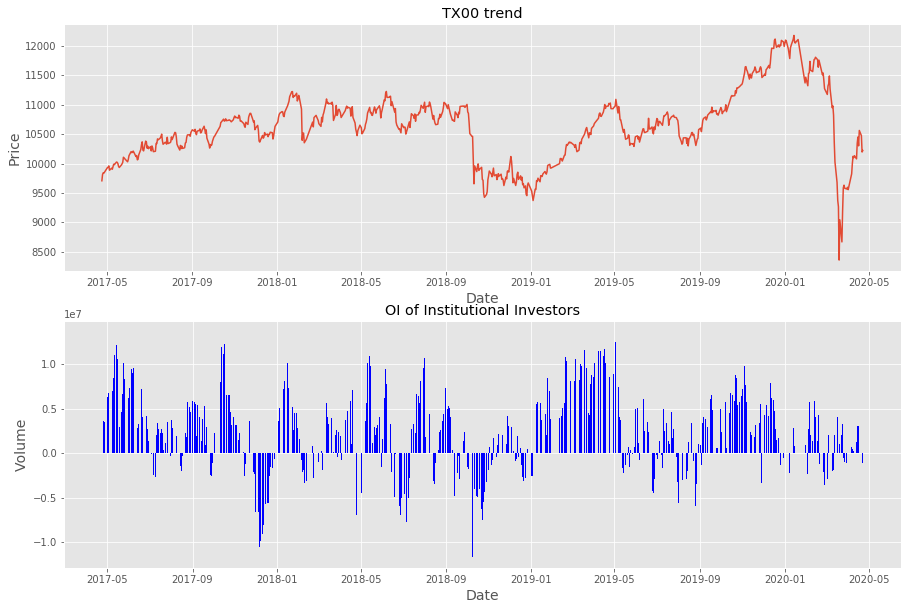

In [134]:
date = TX00['日期']
closePrice = TX00['每日結算價']
OIII = OI['三大法人總和']
date1 = OI['日期']

plt.style.use('ggplot')
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(date, closePrice)
title_name1 = "TX00 trend" 
plt.title(title_name1)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

plt.subplot(212)
plt.bar(date1, OIII, color = 'blue')
title_name2 = "OI of Institutional Investors"
plt.title(title_name2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)

plt.savefig(os.path.join(work_dir, 'Graph', title_name1 + title_name2))
plt.show()

## Run the correlation between MTXOI and TX

In [71]:
dailyMTXR = TX00['每日結算價'].pct_change()

In [72]:
dailyMTXR.head()

0         NaN
1    0.011127
2    0.002853
3   -0.000406
4    0.001830
Name: 每日結算價, dtype: float64

In [139]:
targetY = []
for R in dailyMTXR:
    if R >= 0.005: #rise
        targetY.append(1)
    elif R <= -0.01: #plummet 
        targetY.append(-1)
    else: #bumpy 
        targetY.append(0)

### The change of Futures OI 

In [73]:
dailyOIchange = OI['三大法人總和'] - OI['三大法人總和'].shift(1) # today's OI aggregation minus yesterday's OI aggregation

In [74]:
dailyOIchange.head()

0          NaN
1    3332060.0
2     -59445.0
3    -143837.0
4     589032.0
Name: 三大法人總和, dtype: float64

In [75]:
np.corrcoef(dailyMTXR[1:], dailyOIchange[1:])

array([[1.        , 0.46794229],
       [0.46794229, 1.        ]])

The correlation between the TX return and OIchange is 0.47

### The change of Foreign Investors Institution OptionOI 

In [169]:
ForOptionOIchange = ForOptionOI - ForOptionOI.shift(1)
ForOptionOIchange
ForOptionOIchange['日期'] = ForOptionOI['日期']
ForOptionOIchange['targetY'] = targetY

In [199]:
predictY = [0, 0, ]
for i in range(1, len(ForOptionOIchange)):
    if int(ForOptionOIchange['外資Call未平倉金額'][i]) > 0 and int(ForOptionOIchange['外資Put未平倉契約金額'][i]) < 0: 
        predictY.append(1)
    elif int(ForOptionOIchange['外資Call未平倉金額'][i]) < 0 and int(ForOptionOIchange['外資Put未平倉契約金額'][i]) > 0:
        predictY.append(-1)
    else: 
        predictY.append(0)
        
predictY.pop()

0

In [200]:
ForOptionOIchange['predictY'] = predictY

In [202]:
ForOptionOIchange[0:10]

,日期,外資Call未平倉金額,外資Put未平倉契約金額,targetY,predictY
0,2017-04-24,NaN,NaN,0,0
1,2017-04-25,63265.0,-79929.0,1,0
2,2017-04-26,10812.0,-4347.0,0,1
3,2017-04-27,-15814.0,-46.0,0,1
4,2017-04-28,-10519.0,-16306.0,0,0
5,2017-05-02,65987.0,-18882.0,1,0
6,2017-05-03,12805.0,4986.0,0,1
7,2017-05-04,26383.0,-5601.0,0,0
8,2017-05-05,-64303.0,58873.0,0,1
9,2017-05-08,27693.0,-38710.0,0,-1


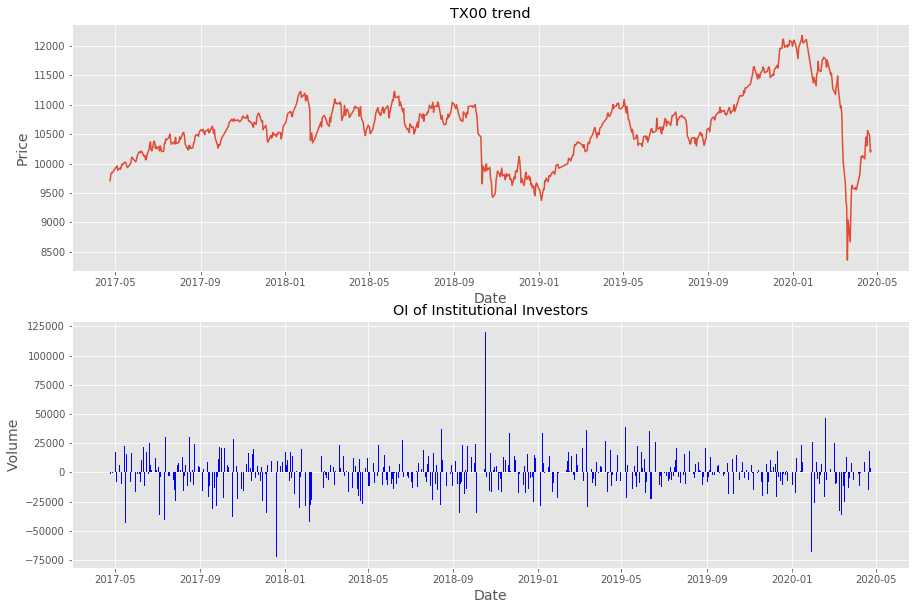

In [136]:
date = TX00['日期']
closePrice = TX00['每日結算價']
OIII = OptionOIchange['三大法人Call未平倉口數']
date1 = OptionOIchange['日期']

plt.style.use('ggplot')
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(date, closePrice)
title_name1 = "TX00 trend" 
plt.title(title_name1)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

plt.subplot(212)
plt.bar(date1, OIII, color = 'blue')
title_name2 = "OI of Institutional Investors"
plt.title(title_name2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)

plt.show()

# Description of the Performance

In [76]:
def get_HPR(pnl):
    days = len(pnl)
    years = days/252
    HPR = pnl[days-1]/100 - 1 
    return HPR

In [93]:
def get_APR(pnl): 
    days = len(pnl)
    years = days/252
    HPR = get_HPR(pnl)
    APR = (HPR + 1)**(1/years) - 1 # annulized the cumulative returns
    return APR

In [104]:
def get_Sharp(pnl, rf): 
    Std = pnl.pct_change().std() # the standard deviation of the return 
    AStd = Std * np.sqrt(252) # annulized the std
    APR = get_APR(pnl)
    SharpRatio = round((APR - rf) / AStd, 4)
    return SharpRatio

In [105]:
def get_mdd(pnl):
    dd = pnl - pnl.cummax()
    dd_pct = dd/pnl.cummax()
    mdd = round(dd_pct.min(), 4)
    return mdd

In [108]:
def print_performance(pnl, rf = 0.01045):
    HPR = get_HPR(pnl) # the cumulative returns
    APR = get_APR(pnl) # annulized the cumulative returns
    SharpRatio = get_Sharp(pnl, rf)
    mdd = get_mdd(pnl)
    
    print("HPR: " + str(HPR)) 
    print("APR: " + str(APR)) 
    print("Sharp Ratio: " + str(SharpRatio))   
    print("mdd: " + str(mdd))

In [101]:
def plot_performance(pnl, date, title_name):
    
    dd = pnl - pnl.cummax()
    dd_pct = dd/pnl.cummax()
    mdd = get_mdd(pnl)
    HPR = get_HPR(pnl)
    APR = get_APR(pnl)
    
    
    plt.style.use('ggplot')
    plt.figure(figsize=(15,10))
    plt.grid()
    plt.subplot(211)
    plt.plot(date, pnl, color = 'Red')
    plt.title(title_name)
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    
    textstr = '\n'.join((
            r'HPR = %.4f' % (HPR, ),
            r'APR = %.4f' % (APR, ), 
            r'MDD = %.4f' % (mdd, )))

    plt.text(date[0], pnl.max()*0.99, textstr, fontsize=10,
    verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))    
    
    

    plt.subplot(212)
    plt.bar(date, dd_pct, color = 'blue')
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Drawdown', fontsize=14)

    plt.savefig(os.path.join(work_dir, 'Graph', title_name))
    plt.show()

# Strategy Development 

* Strategy1: Buy and Hold  
------------
* Strategy2: Based on dailyOIchange
   * Buy @ OpenPrice_T+1 and offset at the @ closePrice_T+1 if 
       * the dailyOIchange is positive;  
   * Sell @ OpenPrice_T+1 and offset at the @ closePrice_T+1 if 
       * the dailyOIchange is negative
------------
* Strategy3: Based on ForOIchange
   * Buy @ OpenPrice_T+1 and offset at the @ closePrice_T+1 if 
       * the Foreign Investor's Call OIchange is positive
       * the Foreign Investor's Put OIchange is negative
   * Sell @ OpenPrice_T+1 and offset at the @ closePrice_T+1 if 
       * the Foreign Investor's Call OIchange is negative
       * the Foreign Investor's Put OIchange is positive
   * Else, do nothing
------------   
* Strategy4: 
    Combine strategy2 and strategy3
    * Buy @ OpenPrice_T+1 and offset at the @ closePrice_T+1 if 
        * Strategy2 says buy and Strategy3 says buy
    * Sell @ OpenPrice_T+1 and offset at the @ closePrice_T+1 if 
        * Strategy2 says sell and Strategy3 says sell  

## Strategy1

In [83]:
def buyandhold(data): 
    length = len(data)
    idx = [True] * length 
    
    data['LS'] = idx
    data['pnl'] = 100 * (1 + data['LS'] * data['CC']).cumprod()
    
    return data['pnl']

In [84]:
pnl = buyandhold(TX00)

In [85]:
pnl

0             NaN
1      101.112714
2      101.401195
3      101.359984
4      101.545436
          ...    
730    106.130229
731    108.829590
732    107.922934
733    105.048424
734    105.316299
Name: pnl, Length: 735, dtype: float64

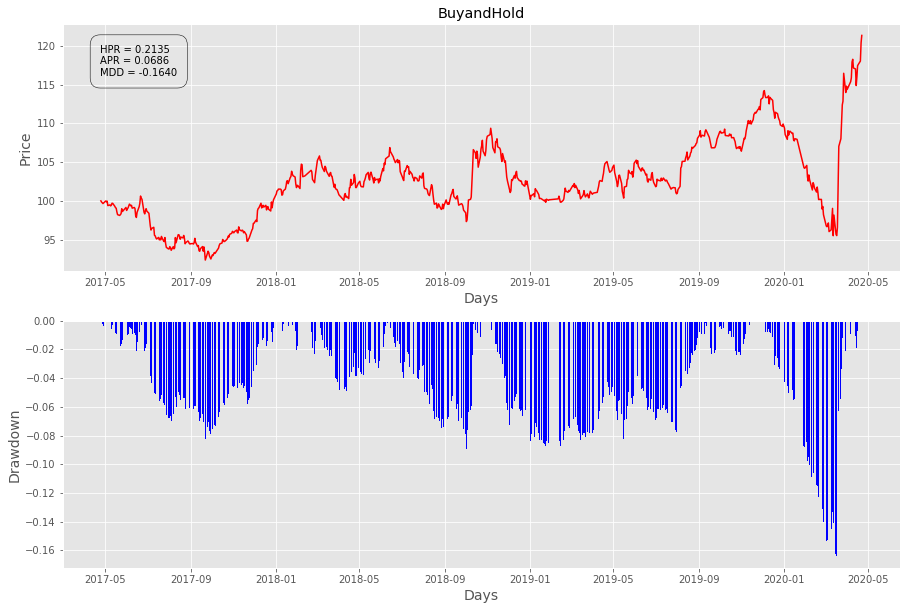

In [214]:
plot_performance(pnl, date = date, title_name = 'BuyandHold')

In [109]:
print_performance(pnl, rf = 0.01045)

HPR: 0.053162991963733086
APR: 0.017917951862802983
Sharp Ratio: 0.0434
mdd: -0.314


## Strategy2 

In [210]:
def strategy2_LS(data): 
    # Buy if the dailyOIchange is positive, Sell if the dailyOIchange is negative
    length = len(data)
    idx = [0] * length
    for i in range(0, len(dailyOIchange)):
        if dailyOIchange[i] > 0: 
            idx[i] = 1
        elif dailyOIchange[i] < 0: 
            idx[i] = -1
        else: 
            idx[i] = 0

    data['LS'] = idx
    data['pnl'] = 100 * (1 + data['LS'].shift(1) * data['OC']).cumprod()
    
    return data['pnl']

In [211]:
pnl_2 = strategy2_LS(TX00)

In [213]:
len(date1)

737

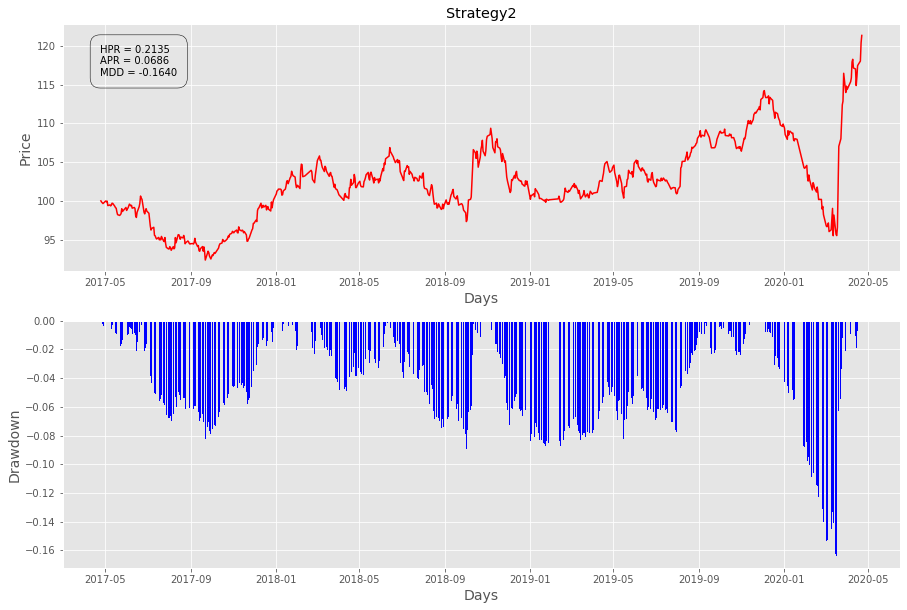

In [215]:
plot_performance(pnl_2, date = date, title_name = 'Strategy2')

In [114]:
print_performance(pnl_2)

HPR: 0.2135494791725967
APR: 0.06861117189067811
Sharp Ratio: 0.5171
mdd: -0.164


## Strategy3 

In [217]:
def strategy3_LS(data): 
    # Buy if the dailyOIchange is positive, Sell if the dailyOIchange is negative
    length = len(data)
    idx = [0] * length
    for i in range(length):
        if ForOptionOIchange['predictY'][i] == 1: 
            idx[i] = 1
        elif ForOptionOIchange['predictY'][i] == -1: 
            idx[i] = -1
        else: 
            idx[i] = 0

    data['LS'] = idx
    data['pnl'] = 100 * (1 + data['LS'].shift(1) * data['OC']).cumprod()
    
    return data['pnl']

In [218]:
pnl_3 = strategy3_LS(TX00)

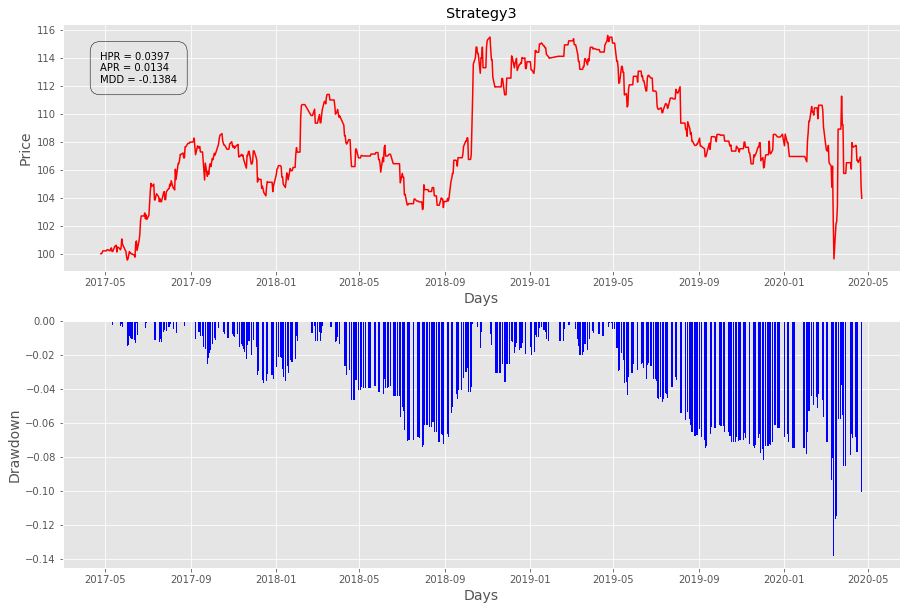

In [219]:
plot_performance(pnl_3, date = date, title_name = 'Strategy3')

In [220]:
print_performance(pnl_3)

HPR: 0.03967034029040817
APR: 0.013427758763657982
Sharp Ratio: 0.033
mdd: -0.1384


## Strategy4 

In [221]:
def strategy4_LS(data): 
    # Buy if the dailyOIchange is positive, Sell if the dailyOIchange is negative
    length = len(data)
    idx = [0] * length
    for i in range(length):
        if ForOptionOIchange['predictY'][i] == 1 and dailyOIchange[i] > 0: 
            idx[i] = 1
        elif ForOptionOIchange['predictY'][i] == -1 and dailyOIchange[i] < 0: 
            idx[i] = -1
        else: 
            idx[i] = 0

    data['LS'] = idx
    data['pnl'] = 100 * (1 + data['LS'].shift(1) * data['OC']).cumprod()
    
    return data['pnl']

In [222]:
pnl_4 = strategy4_LS(TX00)

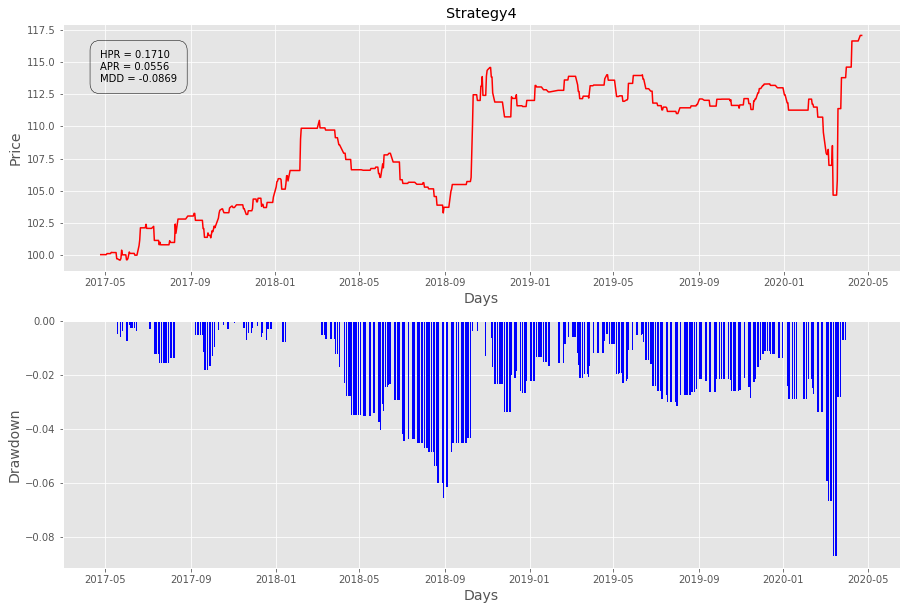

In [223]:
plot_performance(pnl_4, date = date, title_name = 'Strategy4')

In [230]:
print_performance(pnl_4)

HPR: 0.1710387212448523
APR: 0.05562616150045763
Sharp Ratio: 0.6735
mdd: -0.0869


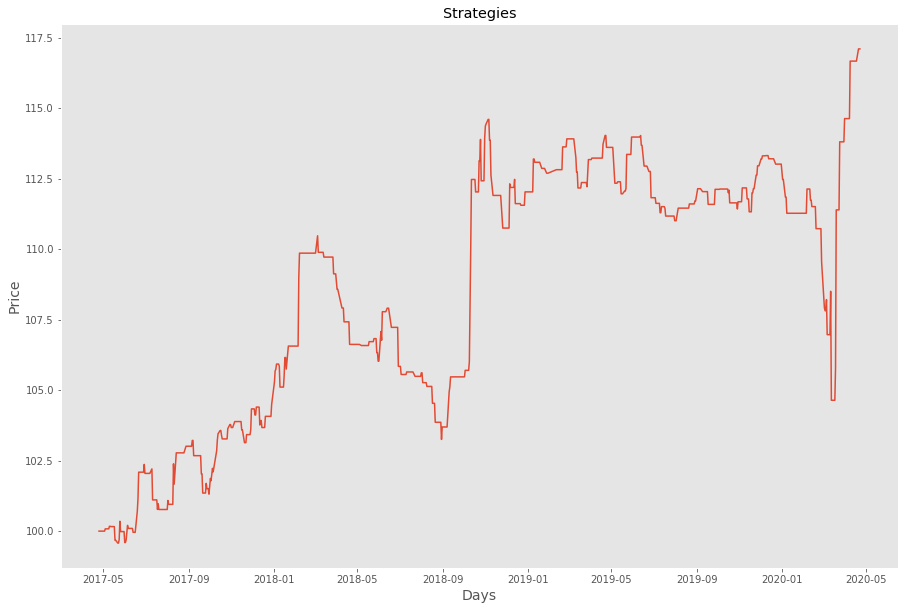

In [229]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))

plt.plot(date, pnl)
plt.plot(date, pnl_2)
plt.plot(date, pnl_3)
plt.title('Strategies')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid()
plt.show()